### Full Name: Alireza Abbasian
### Student ID: 402200253

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torchvision.transforms import Compose, ToTensor, Normalize

from matplotlib.animation import FuncAnimation, PillowWriter 
from PIL import Image

In [2]:
seed_val = 1402


np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device = ",device)

device =  cuda


# Define the MNIST dataset and data loader

<div dir="rtl">
<font face="B Nazanin" size="4">
در این قسمت ابتدا میانگین و جذر واریانس دیتاست را استخراج کردم تا در لود کردن دیتا ست به کمک این مقادیر 
دیتاست را نرمال کنم.
</font>
</div>

In [3]:
# Calculate mean and variance of MNIST dataset
mnist_dataset = datasets.MNIST('./data/', train=True, download=True, transform=ToTensor())
mnist_data = torch.cat([img for img, _ in mnist_dataset], dim=0)
mean_value = torch.mean(mnist_data)
var_value = torch.var(mnist_data)
std_div = torch.sqrt(var_value)
print("mean of dataset = ",mean_value)
print("std of dataset = ",std_div)
# find max value of dataset after normalization
mnist_data = (mnist_data - mean_value) / std_div
max_value_in_mnist = torch.max(mnist_data).item()
min_value_in_mnist = torch.min(mnist_data).item()
print("max of dataset after normalization = ",max_value_in_mnist)
print("min of dataset after normalization = ",min_value_in_mnist)

mean of dataset =  tensor(0.1307)
std of dataset =  tensor(0.3081)
max of dataset after normalization =  2.8215432167053223
min of dataset after normalization =  -0.42407387495040894


In [4]:
batch_size = 64

transform = Compose([
    ToTensor(),
    Normalize((mean_value,), (std_div,)),
])


train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

val_loader = DataLoader(val_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

# VQ-VAE advantages

<div dir="rtl">
<font face="B Nazanin" size="5">
مزایای VQ-VAE
نسبت به VAE
:
فضای نهان در VQVAE
گسسته است و فضای ما محدود به تعدادی بردار است.
به عبارتی  خروجی انکودر
را به نزدیک ترین بردار در فضای 
نهان مپ میکنیم.


در حالت ایده آل هر بعد فضای یک ویژگی معنا دار از دیتا است.
بنابراین با حرکت در یک بعد داریم آن ویژگی را تغییر میدهیم.
VQ
کاری شبیه به این را برای ما انجام میدهد.
به این صورت که هر کدبوک برای ما معنادار خواهد بود و ما تلاش میکنیم که در حالت بهینه
به دیکشنری ای از کدبوک های معنادار برسیم که اتفاقا انکودر ما به خوبی ورودی را به نزدیک یکی از این ها 
مپ میکند.

به عبارتی دیگر ورودی پیوسته تولید میشود ولی گسسته نگاه میشود.

باید دانست که تعداد کدبوک ها کم نیست و جایگشتت های آن ها بسیار زیاد است. پس مشکل تکراری بودن نداریم ولی در هر حال فضا به بزرگی VAE
نیست.

مزیت گسسته بودن آن است که خروجی بی معنا تولید نمیشود.

</font>
</div>

<div dir="rtl">
<font face="B Nazanin" size="5">
فاصله دو بردار به صورت زیر محاسبه میشود
</font>
</div>

distance( i , j )= i^2 + j^2 - 2 \* dot_product( i , j ) = i^2 + j^2 - 2 \* i * transpose( j )

<div dir="rtl">
<font face="B Nazanin" size="5">
در هنگام کوانتایز کردن جا به جایی زیر در ابعاد رخ میدهد تا ابعاد تصویر که همان تعداد بردار های خروجی انکودر است در آخر باشد
</font>
</div>

encoder output(BCHW) -- > during quantization (BHWC) --> quantized output (BCHW)

<div dir="rtl">
<font face="B Nazanin" size="5">
کلاس کوانتایزر زیر 
ابتدا ماتریس فاصله هر بردار خروجی اکودر از هر یک از بردار های کدبوک حساب میکند سپس
نزدیک ترین کدبوک را برای هر بردار انتخاب میکند و آن را به طوری که در دستور کار آمده بود 
detach
کرده و به خروجی میبرد.

علاوه بر آن خطا های فاصله خروجی انکودر از کدبوک ها هم به خروجی میروند
</font>
</div>

In [5]:
class Quantizer(nn.Module):
    def __init__(self, num_codebooks, codebook_dim):
        super(Quantizer, self).__init__()
        
        self.codebook_dim = codebook_dim
        self.num_codebooks = num_codebooks
        
        self.codebook = nn.Embedding(self.num_codebooks, self.codebook_dim)
        std_dev = 1 / self.num_codebooks
        self.codebook.weight.data.normal_(0, std_dev)

    def forward(self, input):

        input = input.permute(0, 2, 3, 1).contiguous()
        flat_input = input.view(-1, self.codebook_dim)
        
        vector_code_distance_matrix = (torch.sum(flat_input**2, dim=1, keepdim=True)+ torch.sum(self.codebook.weight**2, dim=1) - 2 * torch.matmul(flat_input, self.codebook.weight.t()))
            
        nearest_index = torch.argmin(vector_code_distance_matrix, dim=1).unsqueeze(1)


        where_is_nearest = torch.zeros(nearest_index.shape[0], self.num_codebooks, device=input.device)
        where_is_nearest.scatter_(1, nearest_index, 1)
        quantized = torch.matmul(where_is_nearest, self.codebook.weight).view(input.shape)

        
        codebook_loss = F.mse_loss(quantized, input.detach())
        commitment_loss = F.mse_loss(quantized.detach(), input)
        
        quantized = input + (quantized - input).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        return (codebook_loss, commitment_loss), quantized

<div dir="rtl">
<font face="B Nazanin" size="5">
کلاس انکودر زیر از سه لایه کانوولوشنی ساخته شده که دوتای آن ها strid=2
دارند و ابعاد تصویر را نصف میکنند.
دقیقا مسیر برعکس همین در دیکودر طی میشود
</font>
</div>

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1)

        self.conv_2 = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1)
        
        self.conv_3 = nn.Conv2d(in_channels=hidden_dim, out_channels=out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = F.relu(x)
        
        x = self.conv_2(x)
        x = F.relu(x)
        
        x = self.conv_3(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super(Decoder, self).__init__()
        
        self.conv_trans_3  = nn.Conv2d(in_channels=in_channels, out_channels=hidden_dim, kernel_size=3,  stride=1, padding=1)
        
        self.conv_trans_2 = nn.ConvTranspose2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1)
        
        self.conv_trans_1 = nn.ConvTranspose2d(in_channels=hidden_dim, out_channels=out_channels, kernel_size=4, stride=2, padding=1)


    def forward(self, inputs):
        x = self.conv_trans_3(inputs)
        
        x = self.conv_trans_2(x)
        x = F.relu(x)
        
        return self.conv_trans_1(x)

<div dir="rtl">
<font face="B Nazanin" size="5">
مدل در زیر ساخته شده است.
ورودی ابتدا وارد انکودر میشود و خروجی انکودر وارد کوانتایزر میشود و خروجی کوانتایزر وارد دیکودر میشود.
توجه کنید که سایز کانال ورودی ماژول بعدی برابر سایز خروجی قبلی است.
</font>
</div>

In [8]:
class Model(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_codebooks, codebook_dim):
        super(Model, self).__init__()
        
        self.encoder = Encoder(data_dim, hidden_dim, codebook_dim)

        self.quantizer = Quantizer(num_codebooks, codebook_dim)
        
        self.decoder = Decoder(codebook_dim, hidden_dim,data_dim)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized = self.quantizer(z)
        x_recon = self.decoder(quantized)

        return loss, x_recon

<div dir="rtl">
<font face="B Nazanin" size="5">
در زیر تابعی برای ترین نوشته شده که در هر ایپاک مقدار لاس را گزارش میکند
توجه کنید لاس فاصله کدبوک از خروجی انکودر توسط مدل اعلام میشود و ما در تابع زیر با خطای بازسازی آن را جمع میکنیم.

اگر ورودی 
gif
برابر
True
باشد در هر ایپاک بردار های کدبوک در فضای دوبعدی 
(دو بعد اولشان)
یک فریم به گیف اضافه میکنند.
فایل گیف پیوست شده است و قابل مشاهده است که بردار ها همگرا میشوند و به نقاط بهینه خود میل میکنند
</font>
</div>

In [9]:
def train_vq(model, optimizer, num_epochs, train_loader, device, beta, gif = False):
    model.train()
    loss_list = []

    
    i = 0
    img_id = 0
    for epoch_i in range(num_epochs):

        print("epoch_i:", epoch_i)
        print()

        for (data, _) in tqdm(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            (codebook_loss, commitment_loss), data_recon = model(data)
            recon_error = F.mse_loss(data_recon, data)
            loss = recon_error + codebook_loss + beta * commitment_loss
            loss.backward()

            optimizer.step()
            
            loss_list.append(loss.item())

            if gif and i%100==0:
                e = model.quantizer.codebook.weight.data.cpu()
                plt.scatter(e[:, 0], e[:, 1])
                plt.xlim(-5, 5)
                plt.ylim(-5, 5)
                plt.title(f'Codebook Evolution - batch: {i}')
                
                # Save the figure as an image
                filename = f'codebook_evolution_{img_id}.png'
                img_id += 1
                plt.savefig(filename)
                plt.close()  
            i += 1


        print('loss: %.3f' % np.mean(loss_list[-100:]))
        print()
        print("*" * 50)
        print()

    
    if gif:
        image_list = []
        num_epochs = 50
        for id in range(img_id):
            filename = f'codebook_evolution_{id}.png'
            image_list.append(Image.open(filename))

        # Save the list of images as a GIF using Pillow
        output_gif_filename = 'codebook_evolution.gif'
        image_list[0].save(output_gif_filename, save_all=True, append_images=image_list[1:], duration=500, loop=0)
        print(f'GIF saved as: {output_gif_filename}')
        

    return loss_list

<div dir="rtl">
<font face="B Nazanin" size="5">
تنظیمات لازم جهت ترین در زیر قابل اعمال است
</font>
</div>

In [10]:
data_dim = 1

num_epochs = 4

learning_rate = 0.001

hidden_dim = 20

codebook_dim = 2

num_codebooks = 3

beta = 0.25

model = Model(data_dim, hidden_dim, num_codebooks, codebook_dim).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_res_recon_error = train_vq(model, optimizer, num_epochs, train_loader, device, beta, True)

epoch_i: 0



100%|██████████| 938/938 [00:18<00:00, 52.07it/s]


loss: 1.517

**************************************************

epoch_i: 1



100%|██████████| 938/938 [00:17<00:00, 54.42it/s]


loss: 1.229

**************************************************

epoch_i: 2



100%|██████████| 938/938 [00:19<00:00, 48.18it/s]


loss: 1.211

**************************************************

epoch_i: 3



100%|██████████| 938/938 [00:20<00:00, 46.02it/s]


loss: 1.211

**************************************************

GIF saved as: codebook_evolution.gif


# plot loss

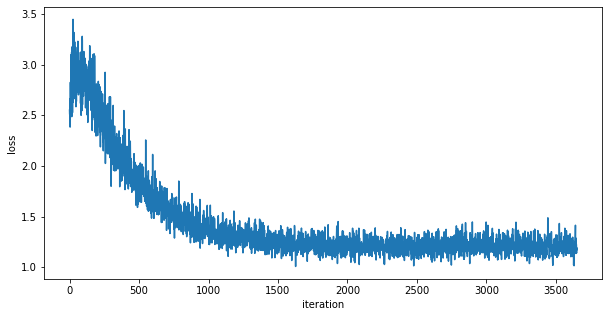

In [11]:
plt.figure(figsize=(10,5))
plt.plot(train_res_recon_error[100:])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
در زیر ورودی و خروجی کوانتایزر و خروجی انکودر برای تعدادی تصویر نمایش داده شده اند
تابعی نوشته ام که به تعداد مشخص از کانال های بردار نهان را میتواند جداگانه بکشد
</font>
</div>

In [12]:
def show_batch_img(input_batch, quantized_output_batch, decoder_output_batch, num, max_q_channel=3):
    for i, (input, quantized_output, decoder_output) in enumerate(zip(input_batch, quantized_output_batch, decoder_output_batch)):

        if i>= num:
            break

        input = input.permute(1,2,0).cpu().data.numpy()
        quantized_output = quantized_output.cpu().data.numpy()
        decoder_output = decoder_output.permute(1,2,0).cpu().data.numpy()

        q_channel = min(max_q_channel,quantized_output.shape[0])
        _, axs = plt.subplots(1, 2 + q_channel, figsize=(4 + 2*q_channel, 2))

        axs[0].imshow(input, cmap='gray')
        axs[0].axis('off')
        axs[0].set_title('input')

        axs[1].imshow(decoder_output, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('decoder output')

        for i in range(q_channel):
            axs[i + 2].imshow(quantized_output[i], cmap='gray')
            axs[i + 2].axis('off')
            axs[i + 2].set_title('quantized out['+ str(i)+"]")

        plt.show()


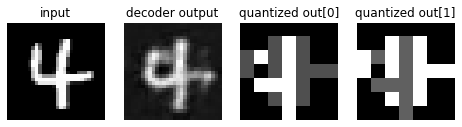

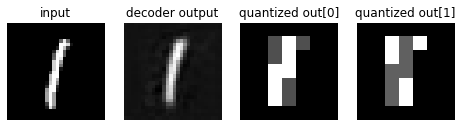

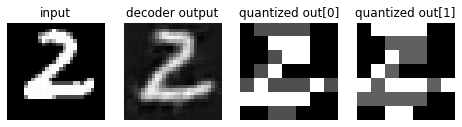

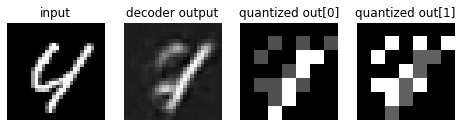

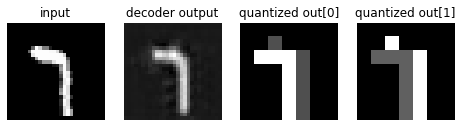

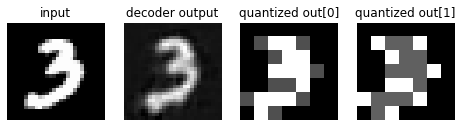

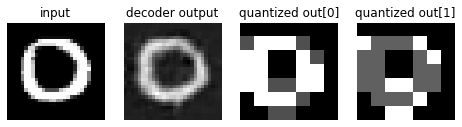

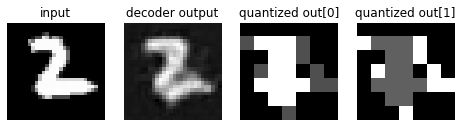

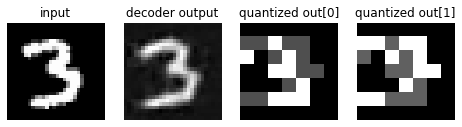

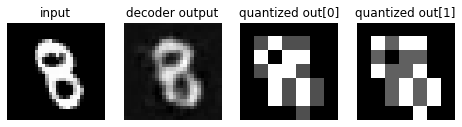

In [13]:
model.eval()

(input, _) = next(iter(val_loader))
input = input.to(device)

encoder_output = model.encoder(input)
_, quantized_output = model.quantizer(encoder_output)
decoder_output = model.decoder(quantized_output)

show_batch_img(input, quantized_output, decoder_output, 10)

<div dir="rtl">
<font face="B Nazanin" size="5">
بردار های کدبوک در زیر نمایش داده شده اند
</font>
</div>

torch.Size([3, 2])


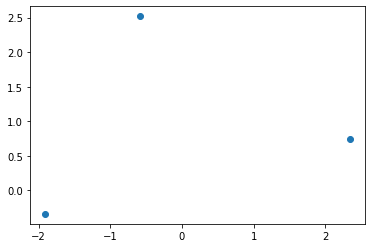

In [14]:
e = model.quantizer.codebook.weight.data.cpu()
print(e.shape)

plt.scatter(e[:,0], e[:,1])
plt.show()

# RGB

<div dir="rtl">
<font face="B Nazanin" size="5">
دیتاست رنگی را ساخته و نمایش داده ایم
</font>
</div>

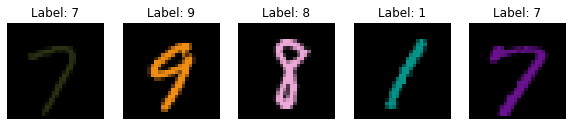

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create a custom dataset class
class RGBMNISTDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Get the original image and label
        img, label = self.original_dataset[idx]

        # Multiply each pixel by three random numbers to create RGB channels
        rgb_img = img.repeat(3, 1, 1) * torch.rand(3, 1, 1)

        return rgb_img, label

# Set batch size
batch_size = 64

# Load the original MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create RGBMNISTDataset instances
rgb_train_data = RGBMNISTDataset(train_data)
rgb_val_data = RGBMNISTDataset(val_data)

# Create data loaders
train_loader = DataLoader(rgb_train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(rgb_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# Plot some images
def plot_images(images, labels):
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Get a batch from the train loader
sample_batch, sample_labels = next(iter(train_loader))

# Plot the RGB images
plot_images(sample_batch, sample_labels)

# low dim, high num

<div dir="rtl">
<font face="B Nazanin" size="5">
تعداد کدبوک هارا کم کم افزایش میدهیم
</font>
</div>

In [16]:
data_dim = 3

num_epochs = 2

learning_rate = 0.001

hidden_dim = 20

codebook_dim = 2

num_codebooks = 10

beta = 0.25

model = Model(data_dim, hidden_dim, num_codebooks, codebook_dim).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_res_recon_error = train_vq(model, optimizer, num_epochs, train_loader, device, beta)

epoch_i: 0



100%|██████████| 938/938 [00:16<00:00, 55.56it/s]


loss: 0.013

**************************************************

epoch_i: 1



100%|██████████| 938/938 [00:16<00:00, 56.52it/s]

loss: 0.015

**************************************************



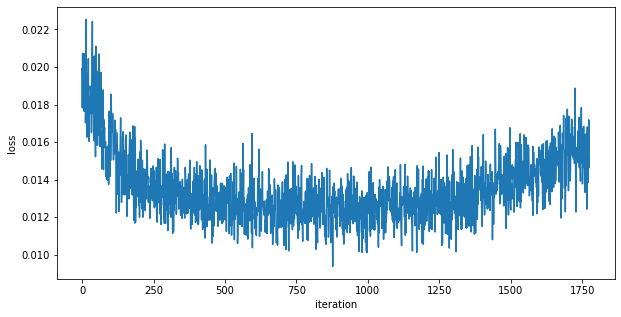

In [17]:
plt.figure(figsize=(10,5))
plt.plot(train_res_recon_error[100:])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


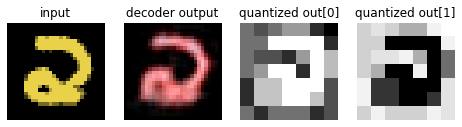

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


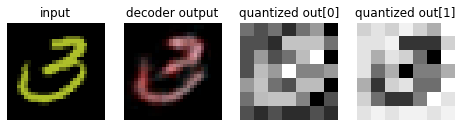

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


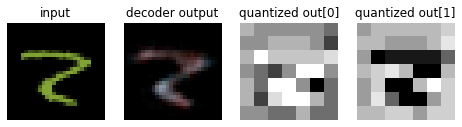

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


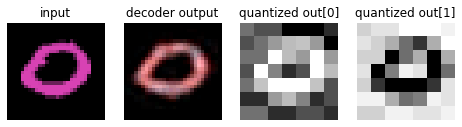

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


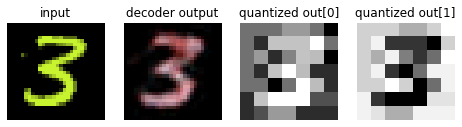

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


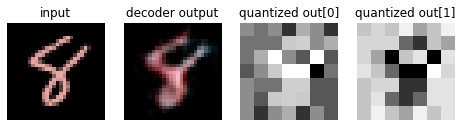

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


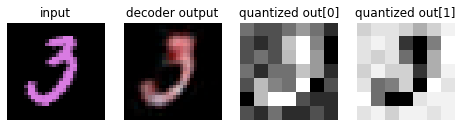

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


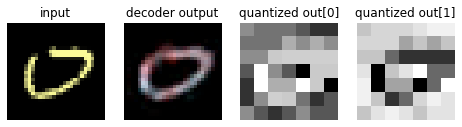

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


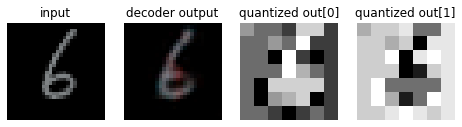

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


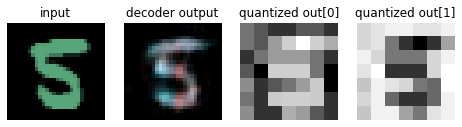

In [18]:
model.eval()

(input, _) = next(iter(val_loader))
input = input.to(device)

encoder_output = model.encoder(input)
_, quantized_output = model.quantizer(encoder_output)
decoder_output = model.decoder(quantized_output)

show_batch_img(input, quantized_output, decoder_output, 10)

In [19]:
data_dim = 3

num_epochs = 2

learning_rate = 0.001

hidden_dim = 20

codebook_dim = 2

num_codebooks = 50

beta = 0.25

model = Model(data_dim, hidden_dim, num_codebooks, codebook_dim).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_res_recon_error = train_vq(model, optimizer, num_epochs, train_loader, device, beta)

epoch_i: 0



100%|██████████| 938/938 [00:16<00:00, 56.40it/s]


loss: 0.009

**************************************************

epoch_i: 1



100%|██████████| 938/938 [00:15<00:00, 60.50it/s]

loss: 0.009

**************************************************



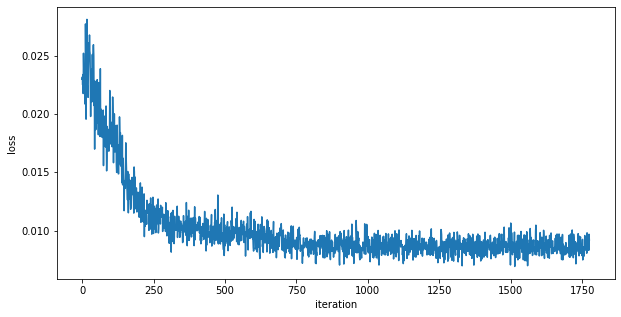

In [20]:
plt.figure(figsize=(10,5))
plt.plot(train_res_recon_error[100:])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


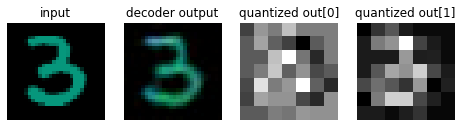

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


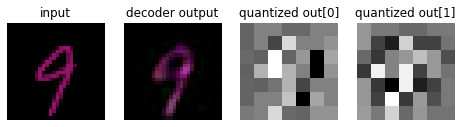

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


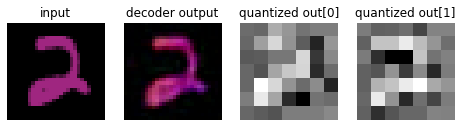

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


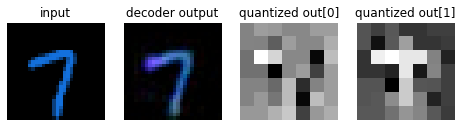

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


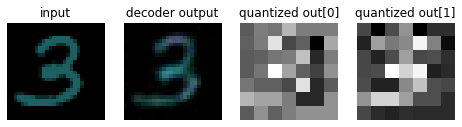

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


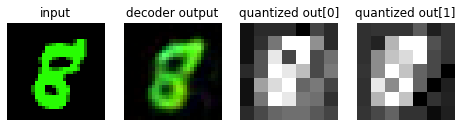

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


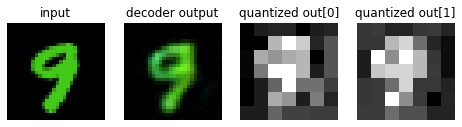

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


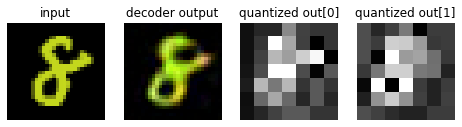

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


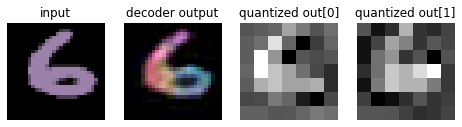

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


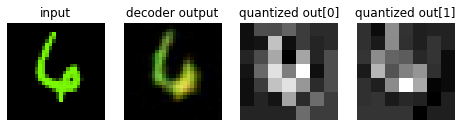

In [21]:
model.eval()

(input, _) = next(iter(val_loader))
input = input.to(device)

encoder_output = model.encoder(input)
_, quantized_output = model.quantizer(encoder_output)
decoder_output = model.decoder(quantized_output)

show_batch_img(input, quantized_output, decoder_output, 10)

<div dir="rtl">
<font face="B Nazanin" size="5">
در بالا مشاهده میکنید که با افزایش کدبوک ها بازسازی بسیار خوب انجام شده است
</font>
</div>

# high dim, low num

<div dir="rtl">
<font face="B Nazanin" size="5">
در تعداد کدبوک کم
ابعاد بردار ها را بالا میبریم
</font>
</div>

In [22]:
data_dim = 3

num_epochs = 2

learning_rate = 0.001

hidden_dim = 20

codebook_dim = 10

num_codebooks = 3

beta = 0.25

model = Model(data_dim, hidden_dim, num_codebooks, codebook_dim).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_res_recon_error = train_vq(model, optimizer, num_epochs, train_loader, device, beta)

epoch_i: 0



100%|██████████| 938/938 [00:15<00:00, 58.64it/s]


loss: 0.057

**************************************************

epoch_i: 1



100%|██████████| 938/938 [00:16<00:00, 56.38it/s]

loss: 0.057

**************************************************



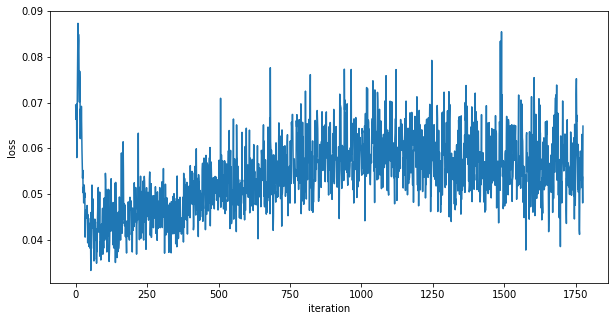

In [23]:
plt.figure(figsize=(10,5))
plt.plot(train_res_recon_error[100:])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
صرفا سه کانال از فضای مخفی را کشیده ام
</font>
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


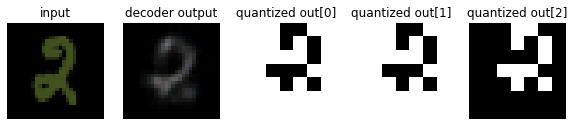

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


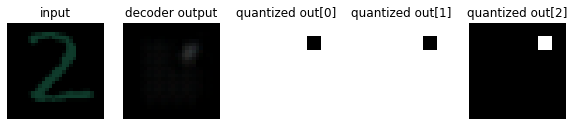

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


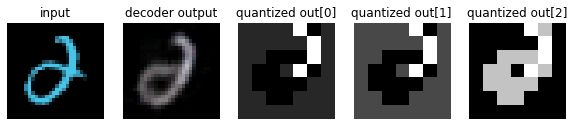

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


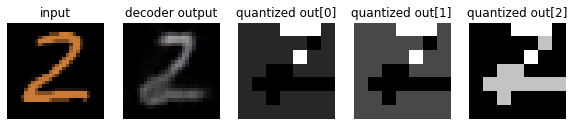

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


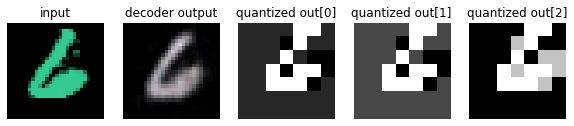

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


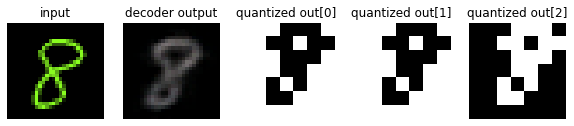

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


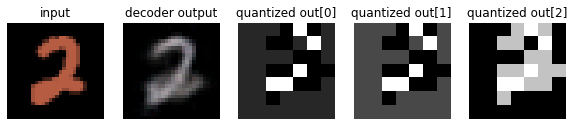

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


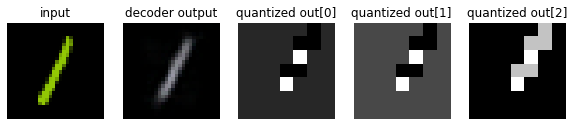

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


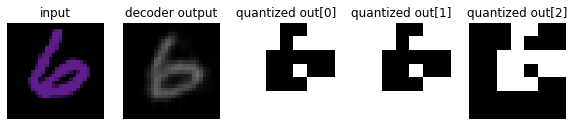

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


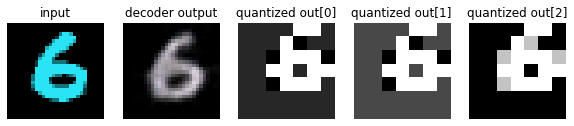

In [24]:
model.eval()

(input, _) = next(iter(val_loader))
input = input.to(device)

encoder_output = model.encoder(input)
_, quantized_output = model.quantizer(encoder_output)
decoder_output = model.decoder(quantized_output)

show_batch_img(input, quantized_output, decoder_output, 10)

In [25]:
data_dim = 3

num_epochs = 2

learning_rate = 0.001

hidden_dim = 20

codebook_dim = 50

num_codebooks = 3

beta = 0.25

model = Model(data_dim, hidden_dim, num_codebooks, codebook_dim).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_res_recon_error = train_vq(model, optimizer, num_epochs, train_loader, device, beta)

epoch_i: 0



100%|██████████| 938/938 [00:15<00:00, 61.13it/s]


loss: 0.031

**************************************************

epoch_i: 1



100%|██████████| 938/938 [00:15<00:00, 60.20it/s]

loss: 0.039

**************************************************



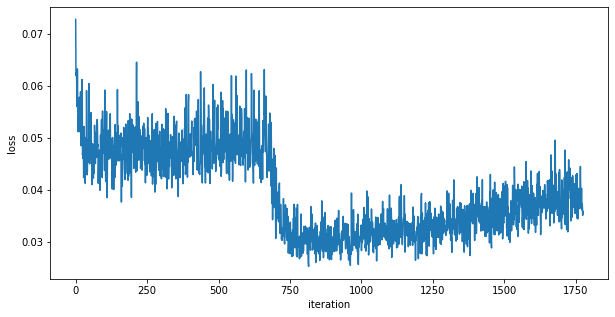

In [26]:
plt.figure(figsize=(10,5))
plt.plot(train_res_recon_error[100:])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


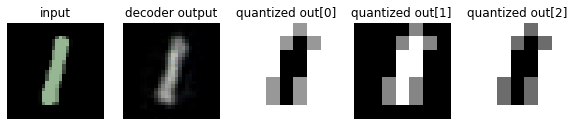

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


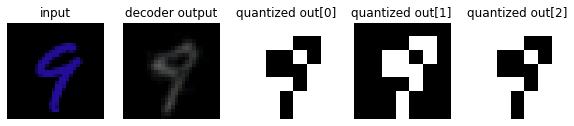

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


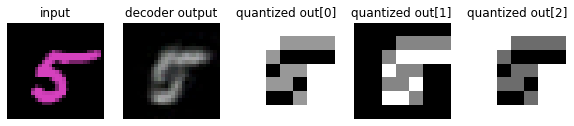

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


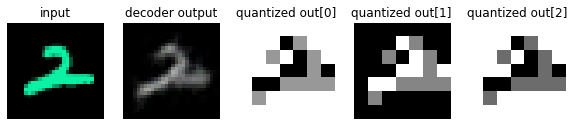

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


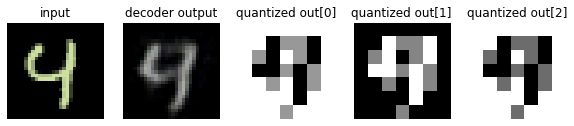

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


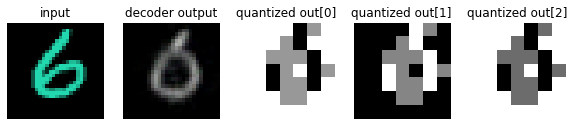

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


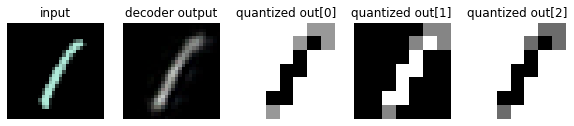

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


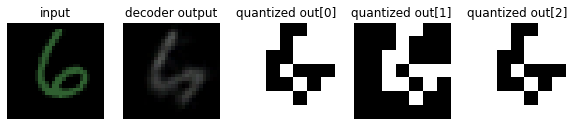

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


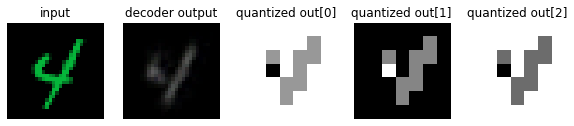

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


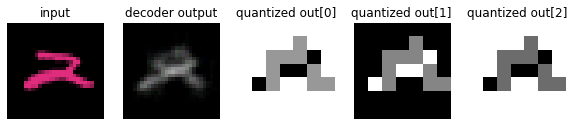

In [27]:
model.eval()

(input, _) = next(iter(val_loader))
input = input.to(device)

encoder_output = model.encoder(input)
_, quantized_output = model.quantizer(encoder_output)
decoder_output = model.decoder(quantized_output)

show_batch_img(input, quantized_output, decoder_output, 10)

<div dir="rtl">
<font face="B Nazanin" size="5">
افزایش بعد به تنهایی کارآمد نیست
</font>
</div>